In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
#sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import gc
import collections

import sys
sys.path.append('../prepare_gustav/src/')

from gustav import ebi, ncbi, nlm, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gtfparse import read_gtf
from sklearn.metrics import auc

In [86]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, Circle, EdgesAndLinkedNodes, TapTool, NodesAndLinkedEdges, OpenURL, Title
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
import networkx as nx

In [87]:
output_notebook()

Loading BokehJS ...

In [4]:
%%time
gene_info = ncbi.gene_info(taxon_ncbi=9606, mode='unambiguous_ensembl')

gene2pubmed = ncbi.gene2pubmed(taxon_ncbi=9606)


ml = ncbi.pubmed(
    'main',
    ['pubmed_id', 'pubdate']   # there are many more columns, including abstracts
).rename(
    columns={'pubdate': 'year'}
).groupby('pubmed_id')['year'].min().reset_index()

gene2pubmed = pd.merge(gene2pubmed, ml, on='pubmed_id', how='left')

../prepare_gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_with_delimiter.drop(column, 1).reset_index(),
../prepare_gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  joined = joined.drop('helper_index', 1)


Wall time: 20.2 s


In [58]:
%%time
# whole network

gene2pubmed_new = gene2pubmed.copy()

valid_pubmed_ids = gene2pubmed_new['pubmed_id'].value_counts()

valid_pubmed_ids = valid_pubmed_ids[(valid_pubmed_ids > 1) & (valid_pubmed_ids <= 10)]

gene2pubmed_new = gene2pubmed_new[gene2pubmed_new['pubmed_id'].isin(valid_pubmed_ids.index)]

gene_count = gene2pubmed[(gene2pubmed['year'] <= 2018)]['gene_ncbi'].value_counts()

genes_of_interest = gene_count[(gene_count.keys().isin(gene_info['gene_ncbi']))].index.values

Wall time: 319 ms


In [59]:
%%time
edge_df = gene2pubmed_new[gene2pubmed_new['gene_ncbi'].isin(genes_of_interest)][['gene_ncbi', 'pubmed_id']]
G = nx.from_edgelist(edge_df.values)

#len(edge_df['gene_ncbi'].value_counts().index.values)

node_list = [int(node) for node in edge_df['gene_ncbi'].value_counts().index.values]

B_weighted = nx.algorithms.bipartite.weighted_projected_graph(G, nodes=node_list)

#B_weighted.add_nodes_from([int(node) for node in list(set(genes_of_interest) - set(B_weighted.nodes))])

G = B_weighted

Wall time: 29 s


In [60]:
gene2go = ncbi.gene2go(taxon_ncbi='9606')
gene2go = gene2go.drop_duplicates(['gene_ncbi', 'go_term'])

../prepare_gustav/src\gustav\ncbi.py:157: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df['_merge'] == 'left_only', :].drop('_merge', 1)


In [68]:
gene_count_dict = gene_count.to_dict()

In [78]:
%%time
ontology = set(gene2go[gene2go['go_term'] == 'regulation of complement activation']['gene_ncbi'].value_counts().index.values)
#pn = set(pn_df['gene_ncbi'].values)
result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
for node in list(G.nodes):
    neighbor_set = set(G[node])
    result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                              'n_neighbors':[len(neighbor_set)], 
                                              'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                               'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))
    
result_df['in_ontology'] = result_df['in_ontology'].astype(bool)

Wall time: 25 s


In [80]:
size_of_pn = len(set(G.nodes) & ontology)
universe_size = len(set(G.nodes))

p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                N=result_df['n_neighbors'], 
                                n=size_of_pn, k=result_df['overlap_with_ontology']-1)

result_df['p'] = p

bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

bonferroni = p*len(p)
bonferroni[bonferroni > 1.0] = 1.0

result_df['fdr'] = bh_fdr
result_df['fwer'] = bonferroni
result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']

auroc: 0.7712039915608851
Wall time: 117 ms


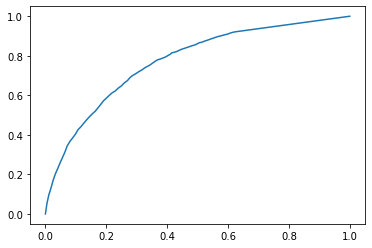

In [170]:
%%time
n = 100
prior = result_df['p'].rank(pct=True)
actual_set = result_df['in_ontology']
roc_tpr = []
roc_fpr = []
for ii in np.arange(0,1+0.5/n,1/n):
    predicted_set = np.array(prior < ii)
    tp = np.sum(predicted_set & actual_set)
    fn = np.sum((~predicted_set) & actual_set)
    tn = np.sum((~predicted_set) & (~actual_set))
    fp = np.sum((predicted_set) & (~actual_set))
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
auroc = auc(roc_fpr, roc_tpr)
print('auroc: ' + str(auroc))
plt.plot(roc_fpr, roc_tpr)

In [139]:
go_list = gene2go['go_id'].value_counts()[0:500].index.values

In [129]:
%%time
# getting the founding dates of top 500 GO terms
go_origin_dates = {}
for go_term in go_list:
    r = requests.get('https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/' + go_term + '/complete', auth=('user', 'pass'))
    json_response = r.json()
    history = pd.DataFrame(json_response['results'][0]['history'])
    origin_str = history[(history['action'] == 'Added') & 
                         (history['category'] == 'TERM')].sort_values('timestamp')['timestamp'].values[0]
    go_origin_dates[go_term] = origin_str

Wall time: 4min 54s


In [142]:
pd.DataFrame.from_dict(go_origin_dates, orient='index').sort_values(0)

,0
GO:0005515,2001-03-30
GO:0005770,2001-03-30
GO:0016491,2001-03-30
GO:0008283,2001-03-30
GO:0006629,2001-03-30
...,...
GO:0098978,2016-06-15
GO:0097711,2016-08-07
GO:0098685,2017-02-08
GO:0062023,2018-04-15


In [143]:
gene2go

,gene_ncbi,go_id,evidence,qualifier,go_term,pubmed_ids,category,taxon_ncbi
0,1,GO:0002576,TAS,-,platelet degranulation,-,Process,9606
2,1,GO:0005576,HDA,-,extracellular region,27068509,Component,9606
5,1,GO:0005615,HDA,-,extracellular space,16502470,Component,9606
7,1,GO:0031093,TAS,-,platelet alpha granule lumen,-,Component,9606
8,1,GO:0034774,TAS,-,secretory granule lumen,-,Component,9606
...,...,...,...,...,...,...,...,...
333314,113523636,GO:0016021,IEA,-,integral component of membrane,-,Component,9606
333315,113523639,GO:0016021,IEA,-,integral component of membrane,-,Component,9606
333316,113839518,GO:0005730,IEA,-,nucleolus,-,Component,9606
333317,113839518,GO:0006396,IEA,-,RNA processing,-,Process,9606


In [171]:
%%time
auroc_p = {}
true_ontology_size = {}
network_ontology_size = {}
number_of_terms = 300

for go_id, ii in zip(go_list[0:number_of_terms], range(number_of_terms)):
    ontology = set(gene2go[gene2go['go_id'] == go_id]['gene_ncbi'].value_counts().index.values)
    #pn = set(pn_df['gene_ncbi'].values)
    result_df = pd.DataFrame({'gene_ncbi':[], 'n_neighbors':[], 'overlap_with_ontology':[], 'in_ontology':[]})
    for node in list(G.nodes):
        neighbor_set = set(G[node])
        result_df = result_df.append(pd.DataFrame({'gene_ncbi':[node], 
                                                  'n_neighbors':[len(neighbor_set)], 
                                                  'overlap_with_ontology':[len(neighbor_set & ontology)], 
                                                   'in_ontology':[bool(node in ontology)], 'n_pubs':[gene_count_dict.get(node)]}))

    result_df['in_ontology'] = result_df['in_ontology'].astype(bool)
    
    size_of_pn = len(set(G.nodes) & ontology)
    
    true_ontology_size[go_id] = len(ontology)
    network_ontology_size[go_id] = size_of_pn
    
    universe_size = len(set(G.nodes))

    p = 1-scipy.stats.hypergeom.cdf(M=universe_size, 
                                    N=result_df['n_neighbors'], 
                                    n=size_of_pn, k=result_df['overlap_with_ontology']-1)

    result_df['p'] = p

    bh_fdr = p*len(p)/(scipy.stats.rankdata(p))
    bh_fdr[bh_fdr > 1.0] = 1.0 # no q-values above 1.0!

    bonferroni = p*len(p)
    bonferroni[bonferroni > 1.0] = 1.0

    result_df['fdr'] = bh_fdr
    result_df['fwer'] = bonferroni
    result_df['exp_val'] = result_df['n_neighbors'] * size_of_pn / universe_size
    result_df['ratio'] = result_df['overlap_with_ontology']/result_df['exp_val']
    
    print(go_id + ' (' + str(ii+1) + ')')
    n = 100
    prior = result_df['p'].rank(pct=True)
    actual_set = result_df['in_ontology']
    roc_tpr = []
    roc_fpr = []
    for ii in np.arange(0,1+0.5/n,1/n):
        predicted_set = np.array(prior < ii)
        tp = np.sum(predicted_set & actual_set)
        fn = np.sum((~predicted_set) & actual_set)
        tn = np.sum((~predicted_set) & (~actual_set))
        fp = np.sum((predicted_set) & (~actual_set))
        tpr = tp/(tp + fn)
        fpr = fp/(fp + tn)
        roc_tpr.append(tpr)
        roc_fpr.append(fpr)
    auroc = auc(roc_fpr, roc_tpr)
    print('AUROC (p-value): ' + str(auroc))
    auroc_p[go_id] = auroc

GO:0005515 (1)
AUROC (p-value): 0.844884003157518
GO:0005634 (2)
AUROC (p-value): 0.840915580963491
GO:0005829 (3)
AUROC (p-value): 0.8352281856488339
GO:0005737 (4)
AUROC (p-value): 0.7717308011490347
GO:0005886 (5)
AUROC (p-value): 0.8567803460435386
GO:0005654 (6)
AUROC (p-value): 0.8500390811423488
GO:0016021 (7)
AUROC (p-value): 0.8174957781687356
GO:0046872 (8)
AUROC (p-value): 0.7681770621145445
GO:0070062 (9)
AUROC (p-value): 0.8154335590110361
GO:0016020 (10)
AUROC (p-value): 0.7712039915608851
GO:0005576 (11)
AUROC (p-value): 0.8567949809156005
GO:0005615 (12)
AUROC (p-value): 0.8767644501369329
GO:0005524 (13)
AUROC (p-value): 0.8533457059176655
GO:0003723 (14)
AUROC (p-value): 0.8637173245214123
GO:0005887 (15)
AUROC (p-value): 0.9035777474840183
GO:0042802 (16)
AUROC (p-value): 0.7687373714207945
GO:0005730 (17)
AUROC (p-value): 0.8065075565855847
GO:0003677 (18)
AUROC (p-value): 0.8304102840428775
GO:0005739 (19)
AUROC (p-value): 0.8134141238713506
GO:0045944 (20)
AUROC (

GO:0070374 (158)
AUROC (p-value): 0.8888264469782804
GO:0004672 (159)
AUROC (p-value): 0.919385409826279
GO:0034220 (160)
AUROC (p-value): 0.965039455073327
GO:0005929 (161)
AUROC (p-value): 0.8627762846489732
GO:0043235 (162)
AUROC (p-value): 0.8837324387854646
GO:0007601 (163)
AUROC (p-value): 0.8638172371058611
GO:0003735 (164)
AUROC (p-value): 0.9047097137608923
GO:0001701 (165)
AUROC (p-value): 0.7373578040286398
GO:0016323 (166)
AUROC (p-value): 0.8793451069164258
GO:0051015 (167)
AUROC (p-value): 0.8934888393190035
GO:0042742 (168)
AUROC (p-value): 0.8845973555572963
GO:0005516 (169)
AUROC (p-value): 0.8958486437641124
GO:0003729 (170)
AUROC (p-value): 0.8879090872820904
GO:0042981 (171)
AUROC (p-value): 0.8850652126954333
GO:0051607 (172)
AUROC (p-value): 0.9077792990105742
GO:0003676 (173)
AUROC (p-value): 0.6516972490166659
GO:0016055 (174)
AUROC (p-value): 0.9157747658451921
GO:0050900 (175)
AUROC (p-value): 0.9363529094709854
GO:0030054 (176)
AUROC (p-value): 0.749861212521

In [194]:
auroc_df = pd.DataFrame({'go_id':go_list, 
              'auroc_p':[auroc_p.get(go_id) for go_id in go_list], 
              'true_ontology_size':[true_ontology_size.get(go_id) for go_id in go_list], 
              'network_ontology_size':[network_ontology_size.get(go_id) for go_id in go_list], 
                         'first_added':[go_origin_dates.get(go_id) for go_id in go_list]}).dropna()
auroc_df = pd.merge(auroc_df, gene2go[['go_id', 'go_term', 'category']].drop_duplicates(), how='left')

In [241]:
auroc_df['first_added'] = pd.to_datetime(auroc_df['first_added'])

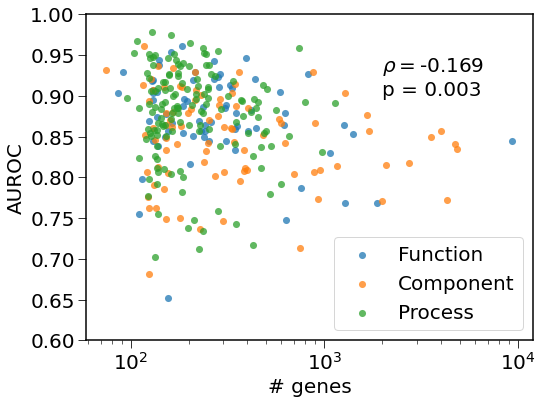

In [346]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
for cat in ['Function', 'Component', 'Process']:
    auroc_df_slice = auroc_df[auroc_df['category'] == cat]
    ax.scatter(auroc_df_slice['network_ontology_size'], auroc_df_slice['auroc_p'], 
               label=cat, s=50, alpha=0.75, linewidth=0)
ax.set_xscale('log')
ax.set_ylim([0.60,1.00])
for ax in [plt.gca()]:
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
leg = ax.legend(fontsize=20, frameon=True)
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xlabel('# genes', fontsize=20)
rho, p = scipy.stats.spearmanr(auroc_df['network_ontology_size'], auroc_df['auroc_p'])
ax.text(s=r'$\rho = $' + "{:.3f}".format(rho) + '\n' + 'p = ' + "{:.3f}".format(p), y=0.9, x=2000, fontsize=20)
plt.savefig('./img/auroc_versus_ontology_size.png', bbox_inches='tight', dpi=200)

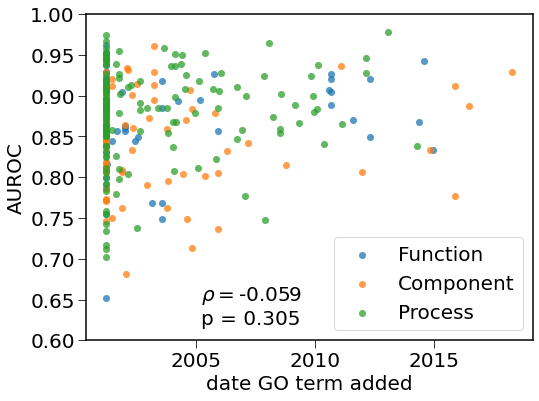

In [347]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
for cat in ['Function', 'Component', 'Process']:
    auroc_df_slice = auroc_df[auroc_df['category'] == cat]
    ax.scatter(auroc_df_slice['first_added'], auroc_df_slice['auroc_p'], label=cat, s=50, alpha=0.75, linewidth=0)
#ax.set_xscale('log')
ax.set_ylim([0.60,1.00])
for ax in [plt.gca()]:
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
        
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
leg = ax.legend(fontsize=20, frameon=True)
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xlabel('date GO term added', fontsize=20)

rho, p = scipy.stats.spearmanr(auroc_df['first_added'].values.astype(int), auroc_df['auroc_p'])
ax.text(s=r'$\rho = $' + "{:.3f}".format(rho) + '\n' + 'p = ' + "{:.3f}".format(p), 
        y=0.62, x=pd.to_datetime('03-15-2005'), fontsize=20)
plt.savefig('./img/auroc_versus_ontology_start_date.png', bbox_inches='tight', dpi=200)

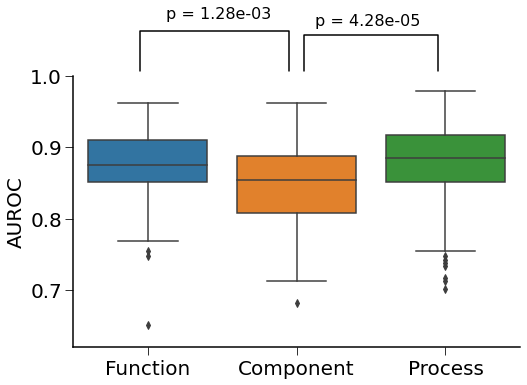

In [348]:
fig = plt.figure(figsize=(8,5))
sns.boxplot(data=auroc_df, x='category', y='auroc_p')

for ax in [plt.gca()]:
    ax.tick_params(axis='both', labelsize=20)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=8)
    #ax.grid()
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
ax.set_ylim([0.62,1.0])
ax.set_ylabel('AUROC', fontsize=20)
ax.set_xlabel(None)
props = {'connectionstyle':'bar','arrowstyle':'-', 'shrinkA':5,'shrinkB':5,'linewidth':1.5}

stat, p = scipy.stats.mannwhitneyu(auroc_df[auroc_df['category'] == 'Function']['auroc_p'], 
                         auroc_df[auroc_df['category'] == 'Component']['auroc_p'])
ax.annotate('', xy=(-0.05,1), xytext=(0.95,1), arrowprops=props)
ax.text(s="p = {:.2e}".format(p), x=0.475, y=1.08, zorder=10, color='k', fontsize=16, ha='center')

stat, p = scipy.stats.mannwhitneyu(auroc_df[auroc_df['category'] == 'Process']['auroc_p'], 
                         auroc_df[auroc_df['category'] == 'Component']['auroc_p'])
ax.annotate('', xy=(1.05,1), xytext=(1.95,1), arrowprops=props)
ax.text(s="p = {:.2e}".format(p), x=1.475, y=1.07, zorder=10, color='k', fontsize=16, ha='center')
plt.savefig('./img/auroc_by_category.png', bbox_inches='tight', dpi=200)

In [301]:
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(X[i],y+7), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

# Call the function
label_diff(0,1,'p=0.0370',[0,1,2],[1,1,1])